# Lab 1 Report

In [6]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def read_image(filename): # Function to read in the filename in the data folder and show the image of the fits file
    arr = fits.getdata(filename)
    hdr = fits.open(filename)
    hdr.info()
    hdr.close()
    plt.imshow(arr, cmap='gray', origin='lower')
    plt.title(filename)
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.show()

def get_data(filename): # Function for getting and displaying the info of the fits file
    hdr = fits.open(filename)
    return hdr[0].header['object'], hdr[0].data, hdr.close()

def mean_std(filename): # Function for computing the mean and the standard deviation of the current fits file data
    arr = fits.getdata(filename)
    x = arr.flatten()
    m1 = np.sum(x)/np.size(x) # <x> = mean
    m2 = np.sum(x**2)/np.size(x) # <x^2>
    m12 = np.absolute(m2-m1**2) # Absolute value of <x^2> - <x>^2
    std = np.sqrt(m12) # square root of <x^2> - <x>^2
    print("mean:", m1)
    print("standard deviation:", std)

def histogram(array,hmin=None, hmax=None, title=None): # Function for creating a histogram of the desired filename
    array = []
    fig, ax = plt.subplots()
    for i in range(43,75): # fetches the filenames every 5 files for the 9 different exposure times
        filename = 'Lab1_data/d20%d.fits'%(i)
        arr = fits.getdata(filename) # stores the filename in an array
        #hdr = fits.open(filename) # opens the file and gets the info of each
        x = arr.flatten()
        if hmin is None:
            hmin = x.min()
        if hmax is None:
            hmax = x.max()
         # initialize bins and empty count arr
        hr = np.arange(hmin, hmax + 1)
        hist = np.zeros(hmax - hmin + 1, dtype=int)
        # count each value in bins
        for value in x:
            if hmin < value < hmax:
                hist[value - hmin] += 1

        ax.plot(hr,hist)
        ax.set_xlim([0,40000])
        #ax.set_ylim([0,100000])
        plt.xlabel('counts(ADU)')
        plt.ylabel('frequency')
    plt.show()



Filename: Lab1_data/d2085.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     157   (1056, 1024)   int16 (rescales to uint16)   


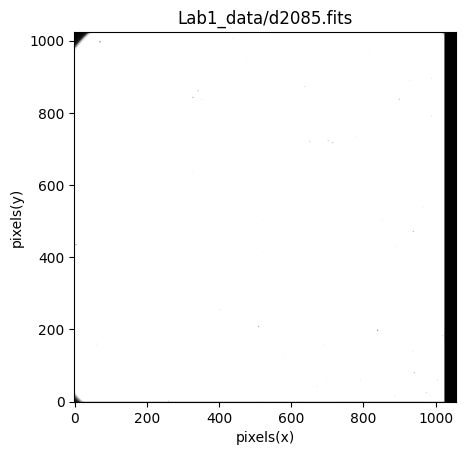

mean: 63487.85912808505
standard deviation: 63487.85011474623


KeyboardInterrupt: 

In [7]:
read_image("Lab1_data/d2085.fits")
get_data("Lab1_data/d2085.fits")
mean_std("Lab1_data/d2085.fits")
histogram("Lab1_data/d2085.fits")

In [32]:
get_data("Lab1_data/d2048.fits")



('flat',
 array([[1063, 1052, 1069, ..., 1018, 1025, 1016],
        [1113, 1092, 1096, ..., 1018, 1027, 1022],
        [1124, 1082, 1085, ..., 1023, 1027, 1017],
        ...,
        [1030, 1035, 1028, ..., 1020, 1007, 1018],
        [1035, 1035, 1037, ..., 1012, 1016, 1010],
        [1046, 1032, 1036, ..., 1003, 1004, 1014]],
       shape=(1024, 1056), dtype=uint16),
 None)

In [103]:
mean_std("Lab1_data/d2048.fits")

mean: 1946.376795913234
standard deviation: 1937.9232528893006


/var/folders/85/g1dhcfl16zj89wp16k8k6bym0000gn/T/ipykernel_83183/752519883.py:39: RuntimeWarning: overflow encountered in scalar add
  hr = np.arange(hmin, hmax + 1)
/var/folders/85/g1dhcfl16zj89wp16k8k6bym0000gn/T/ipykernel_83183/752519883.py:39: RuntimeWarning: overflow encountered in scalar subtract
  hr = np.arange(hmin, hmax + 1)


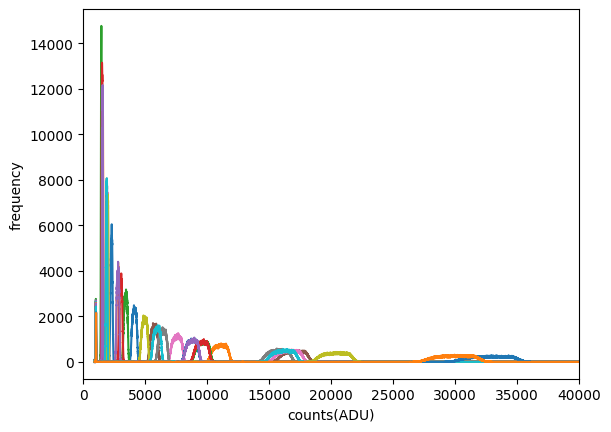

In [22]:
array = []
histogram(array)

In [2]:
def data(x):
    tot = []
    for i in range(43,85):
        filename = 'Lab1_data/d20%d.fits'%(i)
        arr = fits.getdata(filename)
        y = arr.flatten()
        #print(y)
        tot.append(y)
    return tot

In [ ]:
dat = []
dat = data(dat)
dat = np.array(dat)

In [3]:
def zeros(n):
    return [0] * n

In [7]:
def mean(x): # take an empty array and spit out an array with the mean counts of one image of each exposure time
    r = range(32,85)
    n = len(r)
    tot = zeros(n)
    #x = []
    #x = data(x)
    for i in r: # fetches the filenames every 5 files for the 9 different exposure times
        filename = 'Lab1_data/d20%d.fits'%(i)
        arr = fits.getdata(filename)
        y = arr.flatten() # flattens the array so that we can sum over the elements
        m = np.sum(y)/np.size(y)
        tot[i-32] += m
    tot = np.array(tot) # make the output a numpy array
    return tot

In [9]:
xbar = []
xbar = mean(xbar)
xbar

array([ 1098.02885668,  1096.97994625,  1095.83934715,  1094.70750843,
        1094.22102125,  1098.20890577,  1099.88282452,  1098.77467762,
        1096.35280725,  1095.85574526,  1094.62265015,  2309.61505404,
        1622.52944022,  1508.84904156,  1561.65906409,  1608.62973485,
        1946.37679591,  2001.35543268,  1926.79125052,  2008.2757892 ,
        1927.34117543,  4096.26098818,  2830.31408969,  3421.3034335 ,
        3028.87938066,  2810.92073475,  5635.02506418,  7416.96276486,
        6303.50559766,  4888.6676645 ,  5863.41804736,  8585.34904156,
       10799.5416158 ,  9431.12713346,  9370.04008623,  8616.56287823,
       16590.81545466, 16170.44714078, 15333.20166293, 19810.39910334,
       15759.73328469, 31892.60956735, 29083.66966571, 29139.97419877,
       34104.94520615, 35084.19360259, 63463.12925397, 63451.38243612,
       63457.60425637, 63368.4337898 , 63219.27355125, 63508.39428156,
       63495.05644642])

In [22]:
def std(x): # take an empty array and spit out an array with the mean counts of one image of each exposure time
    r = range(32,85)
    n = len(r)
    tot = zeros(n)
    for i in r: # fetches the filenames every 5 files for the 9 different exposure times
        filename = 'Lab1_data/d20%d.fits'%(i)
        arr = fits.getdata(filename)
        y = arr.flatten() # flattens the array so that we can sum over the elements
        m = np.sum(y)/np.size(y)
        for j in y:
            tot[i-32] += ((j-m)**2)/len(y)
    tot = np.sqrt(tot)
    return tot

In [23]:
s = []
s = std(s)
s


array([ 1980.40593553,  1978.61493367,  1979.08492425,  1970.49486159,
        1982.10766422,  1967.4801502 ,  1976.78523228,  1976.25581177,
        1960.28223306,  1972.79233605,  1972.8881346 ,  1942.63557927,
        1967.42916633,  1936.83630842,  1959.18213354,  1950.79538177,
        1936.81259849,  1962.04920625,  1959.64942105,  1946.57623218,
        1948.95169556,  1954.07816969,  1949.16583776,  1963.7870761 ,
        1943.12341178,  1955.08399882,  2046.0977358 ,  2176.40964997,
        2093.74344445,  2011.26282473,  2066.1031132 ,  2294.86389163,
        2553.86408897,  2382.53421768,  2380.09669396,  2296.54503819,
        3412.21914759,  3347.51086956,  3213.78196102,  3956.03794661,
        3278.57458976,  6011.53857317,  5560.07883038,  5568.79480163,
        6378.85431179,  6534.3651978 , 11255.15241826, 11260.56945272,
       11259.39918173, 11258.16876048, 11247.8479536 , 11176.49489613,
       11202.30485417])

In [24]:
y = xbar.flatten()
mom = np.sum(y)/np.size(y)
print(mom)

15292.755443243655


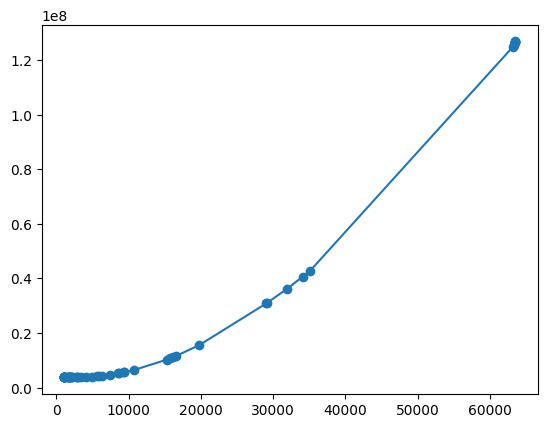

In [25]:
fig, ax = plt.subplots()
xbar.sort()
s.sort()
ax.plot(xbar,s**2,'-o')
#ax.plot(xline,yline,'-')
#plt.yscale('log')
#plt.xscale('log')
plt.show()